## **Instalasi Library dan Setup Awal**
Instal library yang diperlukan dan mount Google Drive untuk mengakses dataset.

In [1]:
# Install TensorFlow dan TensorFlow.js
! pip install tensorflow tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mount Google Drive untuk mengakses file zip dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Ekstraksi Dataset & Import Library**
Mengimpor library yang diperlukan serta menyiapkan dan mengekstrak dataset dari Google Drive.

In [3]:
import zipfile
import os
import shutil
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

import time

In [4]:
# TensorFlow.js (untuk konversi model ke format browser)
import tensorflowjs
print(tensorflowjs.__version__)

4.22.0


In [5]:
# Path file zip dan path ekstraksi
zip_path = '/content/drive/MyDrive/ML_Datasets/all_data.zip'
extract_path = '/content'

# Ekstraksi dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
# Menampilkan folder hasil ekstraksi
for folder in os.listdir('/content/all_data'):
    print(folder)

mountain
forest
sea
street
glacier
buildings


## **Persiapan Data**
Menyiapkan direktori dataset, preprocessing dengan `ImageDataGenerator`, dan membuat generator untuk data pelatihan, validasi, serta pengujian.
   

In [7]:
# Path folder sumber
source_dir = 'all_data'
classes = os.listdir(source_dir)

# Path folder tujuan
base_dir = 'split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Buat folder tujuan
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Stratified split
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    images = os.listdir(cls_path)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Shuffle dan buat full path
    labels = np.array([cls] * len(images))
    images_full = np.array([os.path.join(cls_path, img) for img in images])

    # Split
    train_imgs, temp_imgs = train_test_split(images_full, test_size=0.3, stratify=labels, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, stratify=[cls]*len(temp_imgs), random_state=42)

    # Salin file
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, cls))
    for img_path in val_imgs:
        shutil.copy(img_path, os.path.join(val_dir, cls))
    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, cls))

In [ ]:
# Path ke direktori dataset
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'
test_dir = 'dataset_split/test'

In [ ]:
# Path ke direktori dataset
# base_dir = "/content/intel_image_classification"
# train_dir = os.path.join(base_dir, "seg_train")
# test_dir = os.path.join(base_dir, "seg_test")

In [9]:
# ImageDataGenerator untuk training dan validation dengan split 80:20
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, #
    width_shift_range=0.1, #
    height_shift_range=0.1, #
    shear_range=0.1, #
    zoom_range=0.1, #
    horizontal_flip=True, #
    fill_mode='nearest', #
    # validation_split=0.2  # 20% untuk validasi
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data pelatihan (menggunakan augmentasi)
train_generator = train_datagen.flow_from_directory(
    'split_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    # subset="training"
)

# Generator untuk data validasi
val_generator = train_datagen.flow_from_directory(
    'split_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    # subset="validation"
)


# Generator untuk data pengujian
test_generator = val_test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 11920 images belonging to 6 classes.
Found 11920 images belonging to 6 classes.
Found 2558 images belonging to 6 classes.


## **Arsitektur Model CNN**
Membangun model klasifikasi gambar dengan 3 lapis konvolusi dan fully connected layer.

In [10]:
# Inisialisasi model CNN
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Normalisasi dan Dropout
    BatchNormalization(),
    Dropout(0.3),

    # Fully Connected
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')  # 6 kelas output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Kompilasi & Ringkasan Model**
Menggunakan Adam optimizer dan fungsi loss categorical crossentropy.

In [11]:
optimizer = Adam(learning_rate=1e-4)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,597,638 (36.61 MB)

 Trainable params: 9,597,382 (36.61 MB)

 Non-trainable params: 256 (1.00 KB)

## **Konfigurasi Callbacks**
EarlyStopping, ModelCheckpoint, dan pengurangan learning rate untuk meningkatkan performa training.

In [12]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

## **Training Model**
Melatih model menggunakan data training dan validasi selama 30 epoch (dengan kemungkinan early stopping).

In [13]:
class KeepAliveCallback(tf.keras.callbacks.Callback):
    def __init__(self, interval_sec=60):
        super().__init__()
        self.interval = interval_sec
        self.last_time = time.time()

    def on_batch_end(self, batch, logs=None):
        # Mencetak sesuatu setiap `interval_sec` detik
        now = time.time()
        if now - self.last_time >= self.interval:
            print(f" [Keep-Alive] batch {batch} – notebook masih aktif …")
            self.last_time = now

In [14]:
# Compile ulang (untuk memastikan konfigurasi)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Latih model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr, KeepAliveCallback(interval_sec=60)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


207/373 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.4696 - loss: 1.3751 [Keep-Alive] batch 207 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5113 - loss: 1.2742

373/373 ━━━━━━━━━━━━━━━━━━━━ 174s 454ms/step - accuracy: 0.5115 - loss: 1.2737 - val_accuracy: 0.6603 - val_loss: 1.3004 - learning_rate: 1.0000e-04
Epoch 2/50
 [Keep-Alive] batch 0 – notebook masih aktif …
229/373 ━━━━━━━━━━━━━━━━━━━━ 37s 263ms/step - accuracy: 0.6756 - loss: 0.8663 [Keep-Alive] batch 229 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 171s 458ms/step - accuracy: 0.6775 - loss: 0.8591 - val_accuracy: 0.6530 - val_loss: 0.9309 - learning_rate: 1.0000e-04
Epoch 3/50
 [Keep-Alive] batch 0 – notebook masih aktif …
229/373 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.7208 - loss: 0.7482 [Keep-Alive] batch 229 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7253 - loss: 0.7415

373/373 ━━━━━━━━━━━━━━━━━━━━ 167s 449ms/step - accuracy: 0.7254 - loss: 0.7415 - val_accuracy: 0.7659 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 4/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.7431 - loss: 0.6736 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 167s 447ms/step - accuracy: 0.7446 - loss: 0.6757 - val_accuracy: 0.6913 - val_loss: 0.8619 - learning_rate: 1.0000e-04
Epoch 5/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - accuracy: 0.7757 - loss: 0.6221 [Keep-Alive] batch 238 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 164s 441ms/step - accuracy: 0.7734 - loss: 0.6250 - val_accuracy: 0.7211 - val_loss: 0.7244 - learning_rate: 1.0000e-04
Epoch 6/50
 [Keep-Alive] batch 0 – notebook masih aktif …
231/373 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.7886 - loss: 0.5956 [Keep-Alive] batch 231 – notebook masih aktif …
3

373/373 ━━━━━━━━━━━━━━━━━━━━ 168s 450ms/step - accuracy: 0.7861 - loss: 0.5983 - val_accuracy: 0.8126 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 7/50
 [Keep-Alive] batch 0 – notebook masih aktif …
232/373 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.7865 - loss: 0.5900 [Keep-Alive] batch 232 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 178s 478ms/step - accuracy: 0.7874 - loss: 0.5881 - val_accuracy: 0.7716 - val_loss: 0.6096 - learning_rate: 1.0000e-04
Epoch 8/50
 [Keep-Alive] batch 0 – notebook masih aktif …
235/373 ━━━━━━━━━━━━━━━━━━━━ 35s 256ms/step - accuracy: 0.7998 - loss: 0.5491 [Keep-Alive] batch 235 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7994 - loss: 0.5535

373/373 ━━━━━━━━━━━━━━━━━━━━ 190s 447ms/step - accuracy: 0.7994 - loss: 0.5536 - val_accuracy: 0.8229 - val_loss: 0.4847 - learning_rate: 1.0000e-04
Epoch 9/50
 [Keep-Alive] batch 0 – notebook masih aktif …
229/373 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.7940 - loss: 0.5729 [Keep-Alive] batch 229 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 446ms/step - accuracy: 0.7973 - loss: 0.5608 - val_accuracy: 0.8227 - val_loss: 0.4811 - learning_rate: 1.0000e-04
Epoch 10/50
 [Keep-Alive] batch 0 – notebook masih aktif …
235/373 ━━━━━━━━━━━━━━━━━━━━ 35s 255ms/step - accuracy: 0.8152 - loss: 0.5128 [Keep-Alive] batch 235 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8140 - loss: 0.5152

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 444ms/step - accuracy: 0.8140 - loss: 0.5152 - val_accuracy: 0.8255 - val_loss: 0.4805 - learning_rate: 1.0000e-04
Epoch 11/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.8180 - loss: 0.5065 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 202s 445ms/step - accuracy: 0.8174 - loss: 0.5068 - val_accuracy: 0.8229 - val_loss: 0.4779 - learning_rate: 1.0000e-04
Epoch 12/50
 [Keep-Alive] batch 0 – notebook masih aktif …
231/373 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.8283 - loss: 0.4705 [Keep-Alive] batch 231 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.8260 - loss: 0.4758 - val_accuracy: 0.8127 - val_loss: 0.5021 - learning_rate: 1.0000e-04
Epoch 13/50
 [Keep-Alive] batch 0 – notebook masih aktif …
239/373 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.8202 - loss: 0.4877 [Keep-Alive] batch 239 – notebook masih aktif 

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.8326 - loss: 0.4630 - val_accuracy: 0.8363 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 15/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.8330 - loss: 0.4627 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8341 - loss: 0.4609

373/373 ━━━━━━━━━━━━━━━━━━━━ 178s 479ms/step - accuracy: 0.8341 - loss: 0.4608 - val_accuracy: 0.8568 - val_loss: 0.3889 - learning_rate: 1.0000e-04
Epoch 16/50
 [Keep-Alive] batch 0 – notebook masih aktif …
235/373 ━━━━━━━━━━━━━━━━━━━━ 35s 256ms/step - accuracy: 0.8424 - loss: 0.4302 [Keep-Alive] batch 235 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8407 - loss: 0.4360

373/373 ━━━━━━━━━━━━━━━━━━━━ 190s 445ms/step - accuracy: 0.8407 - loss: 0.4360 - val_accuracy: 0.8654 - val_loss: 0.3633 - learning_rate: 1.0000e-04
Epoch 17/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.8455 - loss: 0.4319 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8446 - loss: 0.4324

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 447ms/step - accuracy: 0.8446 - loss: 0.4325 - val_accuracy: 0.8666 - val_loss: 0.3759 - learning_rate: 1.0000e-04
Epoch 18/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 0.8484 - loss: 0.4218 [Keep-Alive] batch 238 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 201s 443ms/step - accuracy: 0.8475 - loss: 0.4242 - val_accuracy: 0.8527 - val_loss: 0.4011 - learning_rate: 1.0000e-04
Epoch 19/50
 [Keep-Alive] batch 0 – notebook masih aktif …
232/373 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.8482 - loss: 0.4279 [Keep-Alive] batch 232 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8490 - loss: 0.4280

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.8490 - loss: 0.4280 - val_accuracy: 0.8749 - val_loss: 0.3563 - learning_rate: 1.0000e-04
Epoch 20/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.8507 - loss: 0.4238 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 177s 476ms/step - accuracy: 0.8525 - loss: 0.4199 - val_accuracy: 0.7266 - val_loss: 0.7812 - learning_rate: 1.0000e-04
Epoch 21/50
 [Keep-Alive] batch 0 – notebook masih aktif …
235/373 ━━━━━━━━━━━━━━━━━━━━ 35s 256ms/step - accuracy: 0.8577 - loss: 0.3955 [Keep-Alive] batch 235 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.8561 - loss: 0.4004 - val_accuracy: 0.8582 - val_loss: 0.3856 - learning_rate: 1.0000e-04
Epoch 22/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.8568 - loss: 0.3918 [Keep-Alive] batch 233 – notebook masih aktif 

373/373 ━━━━━━━━━━━━━━━━━━━━ 165s 443ms/step - accuracy: 0.8686 - loss: 0.3559 - val_accuracy: 0.8989 - val_loss: 0.2771 - learning_rate: 3.0000e-05
Epoch 27/50
 [Keep-Alive] batch 0 – notebook masih aktif …
239/373 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.8729 - loss: 0.3412 [Keep-Alive] batch 239 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8747 - loss: 0.3401

373/373 ━━━━━━━━━━━━━━━━━━━━ 164s 440ms/step - accuracy: 0.8748 - loss: 0.3401 - val_accuracy: 0.9074 - val_loss: 0.2587 - learning_rate: 3.0000e-05
Epoch 28/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.8721 - loss: 0.3402 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 165s 443ms/step - accuracy: 0.8738 - loss: 0.3394 - val_accuracy: 0.9062 - val_loss: 0.2589 - learning_rate: 3.0000e-05
Epoch 29/50
 [Keep-Alive] batch 0 – notebook masih aktif …
236/373 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.8786 - loss: 0.3292 [Keep-Alive] batch 236 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 177s 475ms/step - accuracy: 0.8790 - loss: 0.3280 - val_accuracy: 0.9049 - val_loss: 0.2581 - learning_rate: 3.0000e-05
Epoch 30/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 0.8796 - loss: 0.3199 [Keep-Alive] batch 238 – notebook masih aktif 

373/373 ━━━━━━━━━━━━━━━━━━━━ 164s 441ms/step - accuracy: 0.8828 - loss: 0.3165 - val_accuracy: 0.9084 - val_loss: 0.2460 - learning_rate: 3.0000e-05
Epoch 33/50
 [Keep-Alive] batch 0 – notebook masih aktif …
239/373 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.8832 - loss: 0.3171 [Keep-Alive] batch 239 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8836 - loss: 0.3157

373/373 ━━━━━━━━━━━━━━━━━━━━ 202s 440ms/step - accuracy: 0.8837 - loss: 0.3157 - val_accuracy: 0.9090 - val_loss: 0.2437 - learning_rate: 3.0000e-05
Epoch 34/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.8897 - loss: 0.2935 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8888 - loss: 0.2984

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 446ms/step - accuracy: 0.8888 - loss: 0.2985 - val_accuracy: 0.9151 - val_loss: 0.2369 - learning_rate: 3.0000e-05
Epoch 35/50
 [Keep-Alive] batch 0 – notebook masih aktif …
239/373 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.8847 - loss: 0.3115 [Keep-Alive] batch 239 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 164s 440ms/step - accuracy: 0.8860 - loss: 0.3084 - val_accuracy: 0.9041 - val_loss: 0.2643 - learning_rate: 3.0000e-05
Epoch 36/50
 [Keep-Alive] batch 0 – notebook masih aktif …
234/373 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.8930 - loss: 0.3095 [Keep-Alive] batch 234 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8921 - loss: 0.3076

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.8921 - loss: 0.3076 - val_accuracy: 0.9155 - val_loss: 0.2347 - learning_rate: 3.0000e-05
Epoch 37/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 257ms/step - accuracy: 0.8940 - loss: 0.2930 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 167s 448ms/step - accuracy: 0.8941 - loss: 0.2920 - val_accuracy: 0.9129 - val_loss: 0.2316 - learning_rate: 3.0000e-05
Epoch 38/50
 [Keep-Alive] batch 0 – notebook masih aktif …
237/373 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - accuracy: 0.8945 - loss: 0.2864 [Keep-Alive] batch 237 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 199s 440ms/step - accuracy: 0.8943 - loss: 0.2887 - val_accuracy: 0.9103 - val_loss: 0.2469 - learning_rate: 3.0000e-05
Epoch 39/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.8876 - loss: 0.3043 [Keep-Alive] batch 233 – notebook masih aktif 

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.9007 - loss: 0.2807 - val_accuracy: 0.9205 - val_loss: 0.2139 - learning_rate: 9.0000e-06
Epoch 42/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 0.8953 - loss: 0.2871 [Keep-Alive] batch 238 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 201s 442ms/step - accuracy: 0.8956 - loss: 0.2855 - val_accuracy: 0.9191 - val_loss: 0.2140 - learning_rate: 9.0000e-06
Epoch 43/50
 [Keep-Alive] batch 0 – notebook masih aktif …
233/373 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - accuracy: 0.9010 - loss: 0.2770 [Keep-Alive] batch 233 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9007 - loss: 0.2792

373/373 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.9007 - loss: 0.2792 - val_accuracy: 0.9233 - val_loss: 0.2069 - learning_rate: 9.0000e-06
Epoch 44/50
 [Keep-Alive] batch 0 – notebook masih aktif …
236/373 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.9017 - loss: 0.2757 [Keep-Alive] batch 236 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 177s 474ms/step - accuracy: 0.9013 - loss: 0.2753 - val_accuracy: 0.9227 - val_loss: 0.2154 - learning_rate: 9.0000e-06
Epoch 45/50
 [Keep-Alive] batch 0 – notebook masih aktif …
239/373 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.8952 - loss: 0.2847 [Keep-Alive] batch 239 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8966 - loss: 0.2806

373/373 ━━━━━━━━━━━━━━━━━━━━ 165s 441ms/step - accuracy: 0.8966 - loss: 0.2806 - val_accuracy: 0.9243 - val_loss: 0.2090 - learning_rate: 9.0000e-06
Epoch 46/50
 [Keep-Alive] batch 0 – notebook masih aktif …
232/373 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.8980 - loss: 0.2809 [Keep-Alive] batch 232 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8990 - loss: 0.2781
Epoch 46: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
373/373 ━━━━━━━━━━━━━━━━━━━━ 167s 447ms/step - accuracy: 0.8990 - loss: 0.2781 - val_accuracy: 0.9224 - val_loss: 0.2084 - learning_rate: 9.0000e-06
Epoch 47/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - accuracy: 0.8963 - loss: 0.2930 [Keep-Alive] batch 238 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8982 - loss: 0.2864

373/373 ━━━━━━━━━━━━━━━━━━━━ 165s 443ms/step - accuracy: 0.8982 - loss: 0.2864 - val_accuracy: 0.9268 - val_loss: 0.2027 - learning_rate: 2.7000e-06
Epoch 48/50
 [Keep-Alive] batch 0 – notebook masih aktif …
236/373 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - accuracy: 0.8997 - loss: 0.2707 [Keep-Alive] batch 236 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 202s 444ms/step - accuracy: 0.9001 - loss: 0.2708 - val_accuracy: 0.9263 - val_loss: 0.2037 - learning_rate: 2.7000e-06
Epoch 49/50
 [Keep-Alive] batch 0 – notebook masih aktif …
231/373 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.9090 - loss: 0.2659 [Keep-Alive] batch 231 – notebook masih aktif …
373/373 ━━━━━━━━━━━━━━━━━━━━ 167s 447ms/step - accuracy: 0.9071 - loss: 0.2684 - val_accuracy: 0.9255 - val_loss: 0.2005 - learning_rate: 2.7000e-06
Epoch 50/50
 [Keep-Alive] batch 0 – notebook masih aktif …
238/373 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 0.9102 - loss: 0.2584 [Keep-Alive] batch 238 – notebook masih aktif 

In [ ]:
# model.save('my_model.keras')

In [15]:
# Evaluasi model di test set
loss, accuracy = model.evaluate(test_generator)
print(f"Akurasi Tes: {accuracy * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8936 - loss: 0.3486
Akurasi Tes: 87.37%


## **Visualisasi Performa Model**
Menampilkan grafik akurasi dan loss selama proses pelatihan untuk mengetahui performa model terhadap data training dan validation.

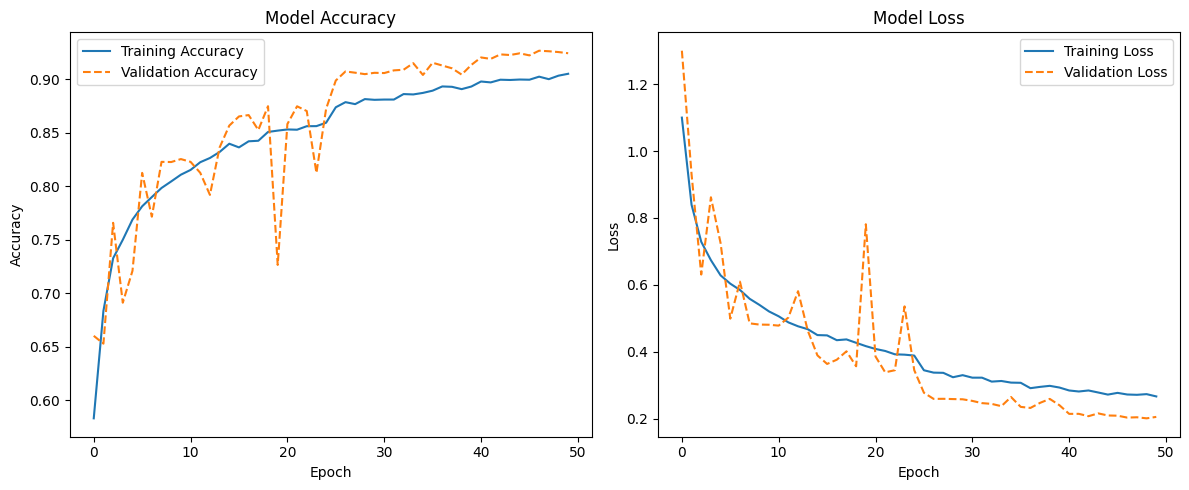

In [16]:
plt.figure(figsize=(12, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Ekspor Model ke Berbagai Format**
Model disimpan dalam format SavedModel, dikonversi ke TensorFlow Lite (.tflite) untuk deployment di perangkat edge, dan juga dikonversi ke TensorFlow.js untuk deployment di web.

### **SavedModel**

In [17]:
os.makedirs('saved_model', exist_ok=True)
model.export('saved_model/my_model')

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134713254812304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254813072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254815376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254812496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254814800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254815952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254816528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254816720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134713254816336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1347132548

### **TensorFlow Lite (.tflite)**

In [18]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()

# Simpan file .tflite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

### **TensorFlow.js**

In [19]:
os.system(f"tensorflowjs_converter --input_format=tf_saved_model "
          f"--output_format=tfjs_graph_model {'saved_model/my_model'} tfjs_model")

0